In [ ]:
sc.install_pypi_package("pandas")
sc.install_pypi_package("matplotlib")

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql import functions as f
from pyspark.sql import Window
from pyspark.sql.types import StringType, DoubleType, IntegerType

import matplotlib.pyplot as plt
import pandas as pd

spark = SparkSession.builder \
                    .appName('PK_BigData_Project') \
                    .config('spark.jars.packages', 'com.amazonaws:aws-java-sdk-bundle:1.12.170') \
                    .config('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.3.3') \
                    .config("spark.driver.memory", "12g") \
                    .config("spark.executor.memory", "12g") \
                    .master('local[3]') \
                    .getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
filePath = "s3a://pkruk-big-data/processed/"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:
badges_df = spark.read.parquet(filePath + 'Badges.parquet')
comments_df = spark.read.parquet(filePath + 'Comments.parquet')
post_history_df = spark.read.parquet(filePath + 'PostHistory.parquet')
post_links_df = spark.read.parquet(filePath + 'PostLinks.parquet')
posts_df = spark.read.parquet(filePath + 'Posts.parquet')
tags_df = spark.read.parquet(filePath + 'Tags.parquet')
users_df = spark.read.parquet(filePath + 'Users.parquet')
votes_df = spark.read.parquet(filePath + 'Votes.parquet')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
comments_df = comments_df.withColumnRenamed('post_id', 'related_post_id')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:
# 1 = Question
# 2 = Answer
# 3 = Orphaned tag wiki
# 4 = Tag wiki excerpt
# 5 = Tag wiki
# 6 = Moderator nomination
# 7 = "Wiki placeholder" (seems to only be the election description)
# 8 = Privilege wiki

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## 1. Liczba postów na przestrzeni czasu

In [7]:
post_id_and_creation_date = posts_df.select('post_id', 'post_creation_date') \
                                    .orderBy('post_creation_date', 'post_id')

post_id_and_creation_date = post_id_and_creation_date \
                                .withColumn('post_creation_date', f.to_date(post_id_and_creation_date.post_creation_date)) \
                                .groupBy('post_creation_date') \
                                .agg(f.count('post_id').alias('post_count')) \
                                .orderBy('post_creation_date')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
window = Window.orderBy('post_creation_date')
post_count_and_creation_date = post_id_and_creation_date.withColumn(
    'cumulative_post_count',
    f.sum('post_count').over(window)).drop('post_count')

post_count_and_creation_date.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+---------------------+
|post_creation_date|cumulative_post_count|
+------------------+---------------------+
|        2013-09-24|                   62|
|        2013-09-25|                  136|
|        2013-09-26|                  241|
|        2013-09-27|                  316|
|        2013-09-28|                  333|
|        2013-09-29|                  367|
|        2013-09-30|                  393|
|        2013-10-01|                  417|
|        2013-10-02|                  437|
|        2013-10-03|                  444|
|        2013-10-04|                  449|
|        2013-10-05|                  453|
|        2013-10-06|                  458|
|        2013-10-07|                  480|
|        2013-10-08|                  498|
|        2013-10-09|                  548|
|        2013-10-10|                  560|
|        2013-10-11|                  576|
|        2013-10-13|                  580|
|        2013-10-14|                  590|
+----------

In [9]:
post_count_and_creation_date_pd = post_count_and_creation_date.toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

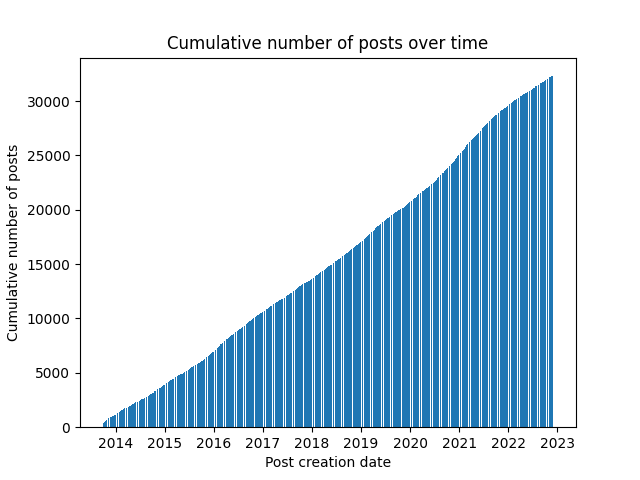

In [10]:
plt.title('Cumulative number of posts over time')
plt.xlabel('Post creation date')
plt.ylabel('Cumulative number of posts')
plt.bar(post_count_and_creation_date_pd['post_creation_date'],
        post_count_and_creation_date_pd['cumulative_post_count'])
plt.show()

%matplot plt

## 2. Czas na forum 10 najdłużej aktywnych użytkonikow pomijając boty

In [11]:
user_id_and_creation_date = users_df.select('user_id', 'user_creation_date')
post_id_creation_date_and_post_owner_user_id = posts_df.select(
    'post_creation_date', 'post_owner_user_id')
comment_id_and_creation_date_and_user_id = comments_df.select(
    'comment_creation_date',
    'user_id').withColumnRenamed('user_id', 'comment_owner_id')

temp = user_id_and_creation_date \
            .join(post_id_creation_date_and_post_owner_user_id, user_id_and_creation_date.user_id == post_id_creation_date_and_post_owner_user_id.post_owner_user_id, 'inner') \
            .drop('post_owner_user_id')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:
temp2 = temp \
            .join(comment_id_and_creation_date_and_user_id, temp.user_id == comment_id_and_creation_date_and_user_id.comment_owner_id, 'inner') \
            .drop('comment_owner_id') \
            .dropDuplicates()

temp2.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+--------------------+---------------------+
|user_id|  user_creation_date|  post_creation_date|comment_creation_date|
+-------+--------------------+--------------------+---------------------+
|   2153|2014-07-31 19:37:...|2015-07-08 21:21:...| 2016-01-27 22:15:...|
|   2153|2014-07-31 19:37:...|2015-07-08 21:21:...| 2014-12-30 14:51:...|
|   2153|2014-07-31 19:37:...|2015-07-08 21:21:...| 2017-06-27 14:31:...|
|   2153|2014-07-31 19:37:...|2015-07-08 21:28:...| 2015-07-26 01:38:...|
|   2618|2014-10-16 09:03:...|2015-08-04 17:45:...| 2016-01-12 10:18:...|
|   2618|2014-10-16 09:03:...|2015-08-04 17:45:...| 2018-08-01 19:14:...|
|  13071|2016-06-05 18:47:...|2016-06-18 12:39:...| 2019-02-12 13:37:...|
|   7411|2015-06-05 11:38:...|2016-09-19 15:59:...| 2022-02-18 11:50:...|
|   7411|2015-06-05 11:38:...|2016-09-19 15:59:...| 2021-10-14 12:10:...|
|   2365|2014-09-06 08:15:...|2017-09-24 16:16:...| 2021-02-15 12:37:...|
|   2365|2014-09-06 08:15:...|2017-09-

In [13]:
user_id_and_last_post_date = temp2.select(
    'user_id', 'post_creation_date').groupBy('user_id').agg(
        f.max('post_creation_date').alias('last_post_date')).withColumnRenamed(
            'user_id', 'user_id1')
user_id_and_last_comment_date = temp2.select(
    'user_id', 'comment_creation_date').groupBy('user_id').agg(
        f.max('comment_creation_date').alias(
            'last_comment_date')).withColumnRenamed('user_id', 'user_id2')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [14]:
temp3 = temp2 \
                                .drop('post_creation_date', 'comment_creation_date') \
                                .distinct() \
                                .join(user_id_and_last_post_date, temp2.user_id == user_id_and_last_post_date.user_id1, 'inner') \
                                .drop('user_id1') \
                                .join(user_id_and_last_comment_date, temp2.user_id == user_id_and_last_comment_date.user_id2, 'inner') \
                                .drop('user_id2') \
                                .withColumn('last_activity', f.greatest('last_post_date', 'last_comment_date')) \
                                .drop('last_post_date', 'last_comment_date') \
                                .withColumn('time_passed', f.unix_timestamp("last_activity") - f.unix_timestamp("user_creation_date")) \
                                .drop('user_creation_date', 'last_activity') \
                                .withColumn('time_passed_days', f.round(f.col('time_passed') / (24*3600))) \
                                .drop('time_passed') \
                                .withColumnRenamed('user_id', 'user_id1') \

user_name_and_time_passed = temp3.join(users_df, users_df.user_id == temp3.user_id1, 'inner') \
                                .select('user_display_name', 'time_passed_days') \
                                .orderBy(f.col('time_passed_days').desc())

user_name_and_time_passed.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+----------------+
|user_display_name|time_passed_days|
+-----------------+----------------+
|       Rory Alsop|          3353.0|
|        Community|          3342.0|
|       dotancohen|          3326.0|
|         astabada|          3313.0|
|         pohuigin|          3311.0|
|    Jason Goemaat|          3309.0|
|          Gabriel|          3307.0|
|           Jordan|          3272.0|
|           Mike G|          3269.0|
|   Ilmari Karonen|          3263.0|
+-----------------+----------------+
only showing top 10 rows

## 3. Porównanie najwyżej i najniżej ocenianych pytań (długość, tagi, liczba odpowiedzi)

In [15]:
lowest_rated_question = posts_df.filter(f.col('post_type_id') == 1) \
                                .select('post_id', 'post_title', 'post_body', 'post_answer_count', 'post_tags', 'post_view_count', 'post_score') \
                                .orderBy('post_score') \
                                .limit(1)

highest_rated_question = posts_df.filter(f.col('post_type_id') == 1) \
                                .select('post_id', 'post_title', 'post_body', 'post_answer_count', 'post_tags', 'post_view_count', 'post_score') \
                                .orderBy(f.col('post_score').desc()) \
                                .limit(1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [16]:
lowest_rated_question.show()
highest_rated_question.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+--------------------+-----------------+---------------+---------------+----------+
|post_id|          post_title|           post_body|post_answer_count|      post_tags|post_view_count|post_score|
+-------+--------------------+--------------------+-----------------+---------------+---------------+----------+
|  49891|What exact materi...|<p>Questions all ...|                3|<star><the-sun>|            145|       -11|
+-------+--------------------+--------------------+-----------------+---------------+---------------+----------+

+-------+--------------------+--------------------+-----------------+---------+---------------+----------+
|post_id|          post_title|           post_body|post_answer_count|post_tags|post_view_count|post_score|
+-------+--------------------+--------------------+-----------------+---------+---------------+----------+
|  24590|How much gold is ...|<p><a href="https...|                2|<the-sun>|          24826|       149|
+-----

In [17]:
highest_rated_question = highest_rated_question.withColumn(
    "total_length",
    f.length("post_title") + f.length("post_body"))
lowest_rated_question = lowest_rated_question.withColumn(
    "total_length",
    f.length("post_title") + f.length("post_body"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [18]:
lowest_rated_question.show()
highest_rated_question.show()

# sprawdzić liczbę komentarzy?

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+--------------------+-----------------+---------------+---------------+----------+------------+
|post_id|          post_title|           post_body|post_answer_count|      post_tags|post_view_count|post_score|total_length|
+-------+--------------------+--------------------+-----------------+---------------+---------------+----------+------------+
|  49891|What exact materi...|<p>Questions all ...|                3|<star><the-sun>|            145|       -11|         743|
+-------+--------------------+--------------------+-----------------+---------------+---------------+----------+------------+

+-------+--------------------+--------------------+-----------------+---------+---------------+----------+------------+
|post_id|          post_title|           post_body|post_answer_count|post_tags|post_view_count|post_score|total_length|
+-------+--------------------+--------------------+-----------------+---------+---------------+----------+------------+
|  24590|

## 4. Procent przypadków kiedy najwyżej oceniana odpowiedź to nie zaakceptowana odpowiedź

In [19]:
just_answers = posts_df.select('post_id', 'post_parent_id', 'post_score').filter(f.col('post_type_id') == 2).withColumnRenamed('post_score', 'answer_score').withColumnRenamed('post_id', 'answer_id').withColumnRenamed('post_score', 'answer_score')
just_questions = posts_df.select('post_id', 'accepted_answer_id').filter(f.col('post_type_id') == 1)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
answers_with_question = just_questions.join(just_answers, just_answers.post_parent_id == just_questions.post_id, 'inner').select('post_id', 'answer_id', 'accepted_answer_id', 'answer_score').orderBy('post_id')
answers_with_question.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------+------------------+------------+
|post_id|answer_id|accepted_answer_id|answer_score|
+-------+---------+------------------+------------+
|      1|      879|               879|          16|
|      1|      652|               879|           9|
|      2|       45|                45|          13|
|      3|       61|              null|           7|
|      3|     1441|              null|           3|
|      4|        5|                 5|          27|
|      4|      343|                 5|           7|
|      7|        8|                 8|          12|
|      7|      817|                 8|           2|
|      7|      818|                 8|          11|
|      9|       41|                35|          12|
|      9|       35|                35|          16|
|      9|       46|                35|          14|
|     14|       21|                21|          10|
|     15|       28|                43|          19|
|     15|     2068|                43|           2|
|     15|   

In [21]:
max_scores = answers_with_question.groupBy('post_id').agg(f.max(answers_with_question.answer_score).alias('max_score')).withColumnRenamed('post_id', 'post_parent_id').orderBy('post_id')
max_scores.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------+---------+
|post_parent_id|max_score|
+--------------+---------+
|             1|       16|
|             2|       13|
|             3|        7|
|             4|       27|
|             7|       12|
|             9|       16|
|            14|       10|
|            15|       22|
|            16|       77|
|            24|       37|
|            26|       19|
|            27|       14|
|            33|       16|
|            34|        9|
|            38|       19|
|            39|        7|
|            42|       14|
|            47|       11|
|            52|       12|
|            58|       12|
+--------------+---------+
only showing top 20 rows

In [22]:
result = answers_with_question.join(max_scores, 
                                     (answers_with_question.post_id == max_scores.post_parent_id) & 
                                     (answers_with_question.answer_score == max_scores.max_score), 
                                     'inner') \
                                .drop('post_parent_id') \
                                .fillna(0, 'max_score') \
                                .withColumnRenamed('post_id', 'question_id') \
                                .withColumnRenamed('answer_score', 'top_answer_score') \
                                .withColumnRenamed('accepted_answer_id', 'questions_accepted_answer_id') \
                                .withColumnRenamed('answer_id', 'best_answer_id') \
                                .drop('max_score') \
                                .orderBy('question_id')

result = result.filter(result.best_answer_id != result.questions_accepted_answer_id)
result.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+--------------+----------------------------+----------------+
|question_id|best_answer_id|questions_accepted_answer_id|top_answer_score|
+-----------+--------------+----------------------------+----------------+
|         24|           224|                          40|              37|
|         66|           120|                       18998|               5|
|         75|            78|                         242|              15|
|         94|            95|                         180|              34|
|         96|           105|                          97|              12|
|        101|           108|                       17933|               7|
|        115|           127|                         236|               7|
|        220|           711|                         235|              13|
|        225|           230|                         250|               5|
|        246|           258|                       13122|               5|
|        253|           2

In [23]:
result = result.join(posts_df, result.questions_accepted_answer_id == posts_df.post_id, 'inner') \
                .select('question_id', 'best_answer_id', 'questions_accepted_answer_id', 'top_answer_score' , 'post_score') \
                .withColumnRenamed('post_score', 'accepted_answer_score') \
                .orderBy('question_id')

result.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+--------------+----------------------------+----------------+---------------------+
|question_id|best_answer_id|questions_accepted_answer_id|top_answer_score|accepted_answer_score|
+-----------+--------------+----------------------------+----------------+---------------------+
|         24|           224|                          40|              37|                   24|
|         66|           120|                       18998|               5|                    2|
|         75|            78|                         242|              15|                   13|
|         94|            95|                         180|              34|                   13|
|         96|           105|                          97|              12|                   12|
|        101|           108|                       17933|               7|                    2|
|        115|           127|                         236|               7|                    5|
|        220|           711|  

In [24]:
num_not_accepted = result.count()
num_total = just_answers.count()
percent = (num_not_accepted / num_total) * 100
print(percent)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

3.8652076868637377

## 5. Rozkład ocen odpowiedzi zaakceptowanych vs pozostałych (średnia, odchylenie, minimum, maksimum)

In [25]:
all_answers = posts_df \
            .filter(f.col('post_type_id') == 2) \
            .select('post_id', 'post_score') \
            .withColumnRenamed('post_id', 'answer_id') \
            .withColumnRenamed('post_score', 'answer_score')

all_answers.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+------------+
|answer_id|answer_score|
+---------+------------+
|     1228|          10|
|     6103|           3|
|     6219|           4|
|    12538|          11|
|    19510|           6|
|    24691|           1|
|    25688|           3|
|    26680|           1|
|     6121|           2|
|    11485|           5|
|    16282|           6|
|    18398|           1|
|    19801|           4|
|    20596|           8|
|    20837|           1|
|    22832|           5|
|    24912|           2|
|    25280|           5|
|    25621|           1|
|    33330|           1|
+---------+------------+
only showing top 20 rows

In [26]:
accepted_answers = all_answers.join(
    posts_df, posts_df.accepted_answer_id == all_answers.answer_id,
    'inner').select('post_id', 'answer_id', 'answer_score').dropDuplicates()
accepted_answers.show()
accepted_answers = accepted_answers.drop('post_id')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------+------------+
|post_id|answer_id|answer_score|
+-------+---------+------------+
|    539|      544|          84|
|   1727|     1734|           6|
|  15109|    15111|           5|
|  47854|    47856|           6|
|  13261|    13264|           0|
|  34366|    34390|           8|
|  44533|    44541|           3|
|  15013|    15014|           1|
|  28800|    28801|          12|
|  31965|    31968|           4|
|  34831|    34852|           4|
|   9919|     9922|           4|
|  24670|    26341|           0|
|  37102|    37104|           4|
|   8080|     8089|           4|
|   1143|     1144|           3|
|  39938|    39940|           4|
|   4836|     4840|           2|
|  18414|    18419|           1|
|  47349|    47357|           3|
+-------+---------+------------+
only showing top 20 rows

In [27]:
remaining_answers = all_answers.subtract(accepted_answers)
remaining_answers.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+------------+
|answer_id|answer_score|
+---------+------------+
|    16526|           4|
|    19187|           1|
|    39683|           7|
|    26442|           2|
|    40008|           2|
|    17828|          -3|
|     6013|           4|
|    16209|           2|
|    13758|           0|
|    49320|           3|
|    11868|           9|
|    14012|           1|
|     8834|           2|
|    19052|           2|
|    45257|          -1|
|    20940|           3|
|    29074|          -2|
|    50022|           4|
|    44762|           8|
|    19472|           3|
+---------+------------+
only showing top 20 rows

In [28]:
accepted_agg_df = accepted_answers.select(
    f.mean("answer_score").alias("mean"),
    f.stddev("answer_score").alias("stddev"),
    f.min("answer_score").alias("min"),
    f.max("answer_score").alias("max"))

remaining_agg_df = remaining_answers.select(
    f.mean("answer_score").alias("mean"),
    f.stddev("answer_score").alias("stddev"),
    f.min("answer_score").alias("min"),
    f.max("answer_score").alias("max"))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
accepted_agg_df.show()
remaining_agg_df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+-----------------+---+---+
|             mean|           stddev|min|max|
+-----------------+-----------------+---+---+
|7.093415699864397|9.861305233491638|-13|170|
+-----------------+-----------------+---+---+

+------------------+-----------------+---+---+
|              mean|           stddev|min|max|
+------------------+-----------------+---+---+
|3.9393965223320833|6.101700461621048|-12| 95|
+------------------+-----------------+---+---+

## 6. Top 10 tagów które wygenerowały najwięcej wyświetleń

In [30]:
temp = posts_df.select('post_id', 'post_tags', 'post_view_count') \
                .filter((f.col('post_tags').isNotNull()) & (f.col('post_view_count').isNotNull())) \
                .withColumn("tags", f.split(f.col('post_tags'), '[<|>]')) \
                .drop('post_tags') \
                .select('post_id', f.explode('tags').alias('tag'), 'post_view_count') \
                .filter(f.col('tag') != '')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
tags_and_view_count = temp.groupBy('tag').agg(
    f.sum('post_view_count').alias('view_count')).orderBy(
        f.col('view_count').desc())
tags_and_view_count.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+----------+
|         tag|view_count|
+------------+----------+
|        star|   1800133|
|     the-sun|   1594160|
|    the-moon|   1545112|
|       orbit|   1059210|
|solar-system|   1033084|
|       earth|    996405|
|   telescope|    969338|
|      planet|    932704|
|     gravity|    873593|
|  black-hole|    846845|
+------------+----------+
only showing top 10 rows

## 7. Liczba postów w czasie dla każdego z top 10 tagów (lineplot/barplot)

In [32]:
top_tags = [
    data[0] for data in tags_and_view_count.select('tag').limit(10).collect()
]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
top_tags

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['star', 'the-sun', 'the-moon', 'orbit', 'solar-system', 'earth', 'telescope', 'planet', 'gravity', 'black-hole']

In [34]:
temp7 = posts_df.select('post_id', 'post_tags', 'post_creation_date') \
                .orderBy('post_creation_date', 'post_id')

temp7 = temp7.withColumn('post_creation_date',
                         f.to_date(temp7.post_creation_date))

temp7.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+------------------+
|post_id|           post_tags|post_creation_date|
+-------+--------------------+------------------+
|      1|<inclination><ama...|        2013-09-24|
|      2|<exoplanet><plane...|        2013-09-24|
|      3|<amateur-observin...|        2013-09-24|
|      4| <the-sun><sunspots>|        2013-09-24|
|      5|                null|        2013-09-24|
|      7| <black-hole><light>|        2013-09-24|
|      8|                null|        2013-09-24|
|      9|<coordinate><asce...|        2013-09-24|
|     10|                null|        2013-09-24|
|     11|                null|        2013-09-24|
|     14|<general-relativity>|        2013-09-24|
|     15|<exoplanet><weather>|        2013-09-24|
|     16|   <the-moon><orbit>|        2013-09-24|
|     17|                null|        2013-09-24|
|     18|                null|        2013-09-24|
|     19|                null|        2013-09-24|
|     20|                null|        2013-09-24|


In [35]:
def print_chart_of_posts_for_tag(df, tag_name):
    plt.plot(df['post_creation_date'], df['cumulative_post_count'], label=tag_name)
    plt.title('Cumulative number of posts over time')
    plt.xlabel('Time')
    plt.ylabel('Cumulative number of posts')
    plt.legend()
    plt.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
plt.clf()

for tag in top_tags:
    temp7_1 = temp7.filter(f.col('post_tags').contains(tag)) \
            .groupBy('post_creation_date') \
            .agg(f.count('post_id').alias('post_count')) \
            .orderBy('post_creation_date')

    window = Window.orderBy('post_creation_date')
    df = temp7_1.withColumn(
        'cumulative_post_count',
        f.sum('post_count').over(window)).drop('post_count')
    df_pd = df.toPandas()
    print_chart_of_posts_for_tag(df_pd, tag)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

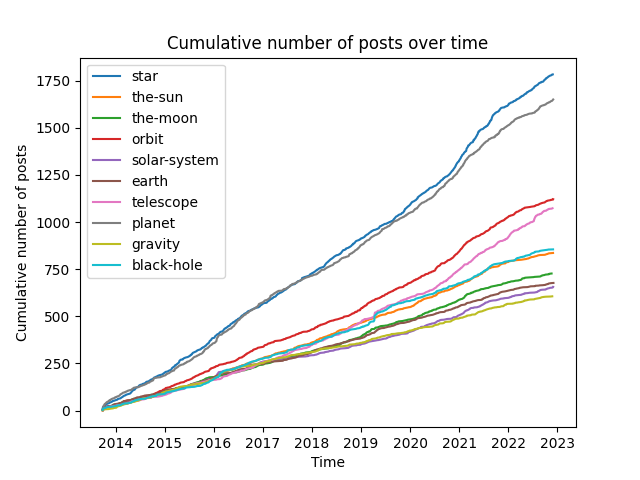

In [37]:
%matplot plt

## 8. Najczęściej pojawiające się słowa w tytułach (z pominięciem stopwords)

In [38]:
post_titles_df = posts_df.select('post_title').dropna()
post_titles_df.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

13155

In [39]:
from pyspark.ml.feature import Tokenizer, StopWordsRemover

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
tokenizer = Tokenizer(inputCol="post_title", outputCol="words")
wordsData = tokenizer.transform(post_titles_df)

remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
filtered_data = remover.transform(wordsData)

word_counts = filtered_data.select("filtered_words") \
    .select(f.explode('filtered_words').alias('word')) \
    .groupBy('word') \
    .agg(f.count('word').alias('num_of_occ')) \
    .orderBy(f.desc('num_of_occ'))

word_counts.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+----------+
|     word|num_of_occ|
+---------+----------+
|     star|       704|
|    black|       650|
|    stars|       628|
|    solar|       590|
|    earth|       542|
|     moon|       504|
|      sun|       500|
|  planets|       407|
|   planet|       395|
|     time|       381|
| universe|       362|
|telescope|       346|
|    light|       326|
|     mass|       314|
|     hole|       294|
|   system|       291|
|    orbit|       286|
|      see|       278|
|calculate|       259|
| distance|       258|
+---------+----------+
only showing top 20 rows

## 9. Procent użytkowników którzy nigdy nic nie zapostowali

In [41]:
# Tutaj będę musiał skorzystać z tabeli posts_df
# Generalnie potrzebuję odnośnie każdego posta znać jego właściciela. Dlatego zdropuje wiersze w których nie ma info o autorze

posts_filtered = posts_df.dropna(subset='post_owner_user_id')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
all_users_count = users_df.count()

user_ids = users_df.select('user_id')

no_posts_users = user_ids.join(posts_df, user_ids.user_id == posts_filtered.post_owner_user_id, 'left').select('user_id', 'post_id').filter(f.col('post_id').isNull()).dropDuplicates().select('user_id')

users_who_never_posted_count = no_posts_users.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
print(users_who_never_posted_count / all_users_count * 100)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

78.06766634884863

## 10. Średni czas od pojawienia się pytania do pojawienia się zaakceptowanej odpowiedzi

In [44]:
posts_temp = posts_df.select('post_id', 'post_creation_date',
                             'accepted_answer_id').filter(
                                 f.col('accepted_answer_id').isNotNull())
posts_temp.show(3)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+--------------------+------------------+
|post_id|  post_creation_date|accepted_answer_id|
+-------+--------------------+------------------+
|     33|2013-09-24 20:00:...|                36|
|     58|2013-09-24 22:29:...|                60|
|   1018|2013-11-26 13:55:...|              1019|
+-------+--------------------+------------------+
only showing top 3 rows

In [45]:
answers_temp = posts_df.select('post_id',
                               'post_creation_date').withColumnRenamed(
                                   'post_creation_date',
                                   'answer_creation_date').withColumnRenamed(
                                       'post_id', 'answer_id')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [46]:
post_creation_date_and_accepted_answer_date = posts_temp \
                                                    .join(answers_temp, posts_temp.accepted_answer_id == answers_temp.answer_id, 'inner') \
                                                    .select('post_id', 'post_creation_date', 'answer_creation_date') \
                                                    .dropDuplicates()

post_creation_date_and_accepted_answer_date.show(3, truncate=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------------+-----------------------+
|post_id|post_creation_date     |answer_creation_date   |
+-------+-----------------------+-----------------------+
|36367  |2020-05-27 06:32:27.937|2021-03-26 04:21:06.17 |
|10123  |2015-03-14 04:05:39.147|2015-03-14 20:52:57.497|
|35052  |2020-02-12 15:04:43.637|2020-02-12 16:18:30.257|
+-------+-----------------------+-----------------------+
only showing top 3 rows

In [47]:
post_and_time_diff = post_creation_date_and_accepted_answer_date \
                        .withColumn("time_diff", f.unix_timestamp("answer_creation_date") - f.unix_timestamp("post_creation_date")) \
                        .select('post_id', 'time_diff') \
                        .withColumn('time_diff_hours', f.round(f.col('time_diff') / 3600)) \
                        .drop('time_diff')

post_and_time_diff.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------------+
|post_id|time_diff_hours|
+-------+---------------+
|  36367|         7270.0|
|  10123|           17.0|
|  35052|            1.0|
|  29011|            1.0|
|  26424|           22.0|
|  28664|            4.0|
|  13653|            2.0|
|  44752|            4.0|
|  50282|          765.0|
|  39136|           32.0|
|  18784|           54.0|
|  32440|            9.0|
|  30234|            8.0|
|  23730|           24.0|
|   6336|            3.0|
|  48828|           15.0|
|   8571|            0.0|
|  16286|            1.0|
|  47285|          877.0|
|  21261|            9.0|
+-------+---------------+
only showing top 20 rows

In [48]:
avg_answer_time_in_hrs = post_and_time_diff.select(
    f.mean('time_diff_hours')).first()[0]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [49]:
avg_time_days = round(avg_answer_time_in_hrs / 24)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [50]:
print(avg_time_days)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

22

## 11. Ile zadano pytań bez tagów?

In [51]:
questions = posts_df.filter(f.col('post_type_id') == 1).select('post_id', 'post_tags')
questions_without_tags_count = questions.filter((f.col('post_tags').isNull()) | (f.col('post_tags') == '')).count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [52]:
all_questions_count = questions.count()
no_tags_percent = questions_without_tags_count / all_questions_count * 100
print(no_tags_percent)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0.0

## 12. Jaka jest zależność między liczbą wyświetleń a liczbą odpowiedzi?

In [53]:
temp12 = posts_df.select('post_id', 'post_answer_count', 'post_view_count').dropna(how='any', subset=['post_answer_count', 'post_view_count'])
temp12.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----------------+---------------+
|post_id|post_answer_count|post_view_count|
+-------+-----------------+---------------+
|     33|                4|          12183|
|  14700|                0|            552|
|  18666|                1|            358|
|  24241|                1|            129|
|  25699|                1|            100|
|     58|                2|            767|
|   1018|                2|          30683|
|   5907|                2|            366|
|  10854|                0|            471|
|  11486|                1|           1008|
|  14035|                1|             60|
|  20654|                3|            855|
|  20682|                2|            712|
|  23508|                1|            111|
|  26054|                2|            184|
|  32190|                0|            142|
|   7663|                2|           2619|
|   8531|                1|            284|
|  17984|                3|            367|
|  19039|                5|     

In [54]:
mean = temp12.select(f.mean(f.col("post_view_count"))).collect()[0][0]
stddev = temp12.select(f.stddev(f.col("post_view_count"))).collect()[0][0]

temp12_filtered = temp12.filter((f.col("post_view_count") > (mean - 3 * stddev)) & (f.col("post_view_count") < (mean + 3 * stddev)))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

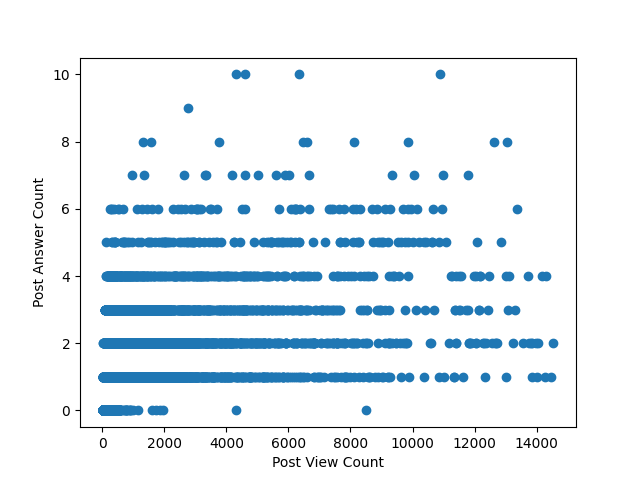

In [55]:
from pyspark.ml.feature import VectorAssembler

plt.clf()

x = temp12_filtered.select("post_view_count").collect()
y = temp12_filtered.select("post_answer_count").collect()

plt.scatter(x, y)
plt.xlabel("Post View Count")
plt.ylabel("Post Answer Count")
plt.show()

%matplot plt

## 13. Jak wygląda liczba odznak na przestrzeni lat? (TODO - osobno dla odznak)

In [56]:
temp13 = badges_df.withColumn("year", f.year(badges_df["badge_aquire_date"]))
result = temp13.groupBy("year").count().orderBy('year')
result.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+-----+
|year|count|
+----+-----+
|2013| 1515|
|2014| 4195|
|2015| 4713|
|2016| 6264|
|2017| 6215|
|2018| 6242|
|2019| 7231|
|2020| 6911|
|2021| 7717|
|2022| 5907|
+----+-----+

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

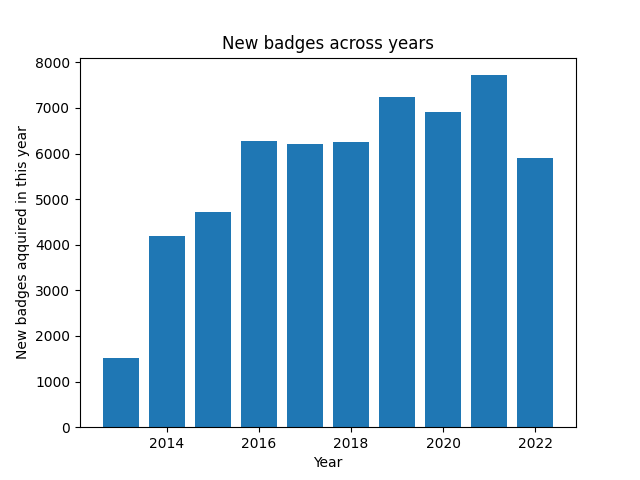

In [57]:
plt.clf()
result_pdf = result.toPandas()

plt.bar(result_pdf["year"], result_pdf["count"])
plt.xlabel("Year")
plt.ylabel("New badges aqquired in this year")
plt.title("New badges across years")
plt.show()
%matplot plt

## 14. W jaki dzień tygodnia/o jakiej porze pojawia się najwięcej odpowiedzi?

In [68]:
def categorize_time(time_str):
    hour = int(time_str.split(":")[0])
    if 5 <= hour < 9:
        return "early morning"
    elif 9 <= hour < 12:
        return "late morning"
    elif 12 <= hour < 14:
        return "noon"
    elif 14 <= hour < 17:
        return "early afternoon"
    elif 17 <= hour < 21:
        return "late afternoon"
    elif 21 <= hour < 23:
        return "evening"
    else:
        return "night"

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [69]:
udf_categorize_time = f.udf(categorize_time, StringType())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [70]:
temp14 = posts_df.select('post_id', 'post_parent_id', 'accepted_answer_id', 'post_type_id', 'post_creation_date').withColumnRenamed('post_parent_id', 'original_post_id')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [71]:
answers_14 = temp14.filter(f.col('post_type_id') == 2) \
                    .select('post_id', 'post_creation_date') \
                    .withColumnRenamed('post_id', 'answer_id') \
                    .withColumnRenamed('post_creation_date', 'answer_creation_date')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [72]:
answers_14 = answers_14 \
                .withColumn('weekday', f.date_format('answer_creation_date', 'E')) \
                .withColumn('hour_minute', f.date_format('answer_creation_date', "HH:mm")) \
                .withColumn("daytime", udf_categorize_time(f.col('hour_minute'))) \
                .drop('answer_creation_date', 'hour_minute')

answers_14.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------+-------+---------------+
|answer_id|weekday|        daytime|
+---------+-------+---------------+
|     1228|    Sat|        evening|
|     6103|    Mon| late afternoon|
|     6219|    Fri|early afternoon|
|    12538|    Wed|   late morning|
|    19510|    Sun|   late morning|
|    24691|    Wed|early afternoon|
|    25688|    Fri|  early morning|
|    26680|    Mon|        evening|
|     6121|    Wed|          night|
|    11485|    Tue| late afternoon|
|    16282|    Sat|           noon|
|    18398|    Mon|early afternoon|
|    19801|    Wed|           noon|
|    20596|    Sat|  early morning|
|    20837|    Mon| late afternoon|
|    22832|    Sun|early afternoon|
|    24912|    Mon|early afternoon|
|    25280|    Sun|early afternoon|
|    25621|    Sun|   late morning|
|    33330|    Wed| late afternoon|
+---------+-------+---------------+
only showing top 20 rows

In [73]:
grouped_answers = answers_14.groupBy(["weekday", "daytime"]).count().orderBy(f.col('count').desc())
grouped_answers.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+---------------+-----+
|weekday|        daytime|count|
+-------+---------------+-----+
|    Tue| late afternoon|  656|
|    Wed| late afternoon|  651|
|    Mon| late afternoon|  649|
|    Thu| late afternoon|  643|
|    Fri| late afternoon|  588|
|    Wed|          night|  502|
|    Sun| late afternoon|  501|
|    Sat| late afternoon|  492|
|    Tue|early afternoon|  485|
|    Tue|          night|  469|
|    Wed|early afternoon|  459|
|    Fri|          night|  457|
|    Mon|early afternoon|  453|
|    Thu|          night|  452|
|    Thu|early afternoon|  430|
|    Sat|          night|  426|
|    Mon|          night|  421|
|    Fri|early afternoon|  414|
|    Sun|          night|  404|
|    Wed|  early morning|  403|
+-------+---------------+-----+
only showing top 20 rows

## 15. Badanie podobieństw między tagami

### Klasteryzacja słów za pomocą k-means

In [64]:
tags_15 = tags_df.select('tag_name').distinct()
tags_unique = [data[0] for data in tags_15.select('tag_name').collect()]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [105]:
def group_by_second(lst):
    return {k: [x for x, y in lst if y == k] for k in {y for x, y in lst}}

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [131]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(tags_unique)

kmeans = KMeans(n_clusters=10)
kmeans.fit(X)

labels = kmeans.labels_

word_and_group = list(zip(tags_unique, labels))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [132]:
result = group_by_second(word_and_group)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [133]:
for key in result.keys():
    print(result[key])
    print()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['m31', 'transits-other-than-sun', 'planetary-science', 'image-processing', 'frame-of-reference', 'infrared', 'detectors', 'standard-candle', 'asteroid-belt', 'albedo', 'kuiper-belt', 'differentiation', 'hypergiants', 'temperature', 'ascension', 'quantum-mechanics', 'ecliptic', 'parallax', 'distances', 'universe', 'interstellar-travel', 'circumgalactic-medium', 'astropy', 'neutrinos', 'correction', 'gas', 'horizon', 'mond', 'sloan-dss', 'globular-clusters', 'gravitational-lensing', '99942-apophis', 'origin-of-life', 'multiverse', 'oumuamua', 'planetary-transits', 'future', 'betelgeuse', 'angular-resolution', 'asteroids', 'magnetic-field', 'tidal-forces', 'solar-system', 'resource-request', 'particles', 'earth', 'software', 'nebulae', 'nicer', 'ice', 'solar-wind', 'water', 'radial-velocity', 'nebula', 'parker-solar-probe', 'mass-loss', 'umbra', 'elliptic', 'mars', 'axion', 'inclination', 'tess', 'proton', 'plasma-physics', 'azimuth', 'alignment', 'velocity', 'nasa', 'app', 'right-ascens

### Model semantyczny: Można użyć modelu semantycznego, takiego jak word2vec lub GloVe, aby porównać semantyczne relacje między słowami i zobaczyć, czy są blisko siebie.

### Słownik synonimów: Można użyć gotowego słownika synonimów, aby zobaczyć, czy dane słowa są zdefiniowane jako synonimy.